In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction

In this chapter, we will use Game of Thrones as a case study to practice our newly learnt skills of network analysis.

It is suprising right? What is the relationship between a fatansy TV show/novel and network science or Python(not dragons).

If you haven't heard of Game of Thrones, then you must be really good at hiding. Game of Thrones is a hugely popular television series by HBO based on the (also) hugely popular book series A Song of Ice and Fire by George R.R. Martin. In this notebook, we will analyze the co-occurrence network of the characters in the Game of Thrones books. Here, two characters are considered to co-occur if their names appear in the vicinity of 15 words from one another in the books.

The figure below is a precusor of what we will analyse in this chapter.

![](../../images/got.png)


The dataset is publicly avaiable for the 5 books at https://github.com/mathbeveridge/asoiaf. This is an interaction network and were created by connecting two characters whenever their names (or nicknames) appeared within 15 words of one another in one of the books. The edge weight corresponds to the number of interactions. 


Data and figure Credits:

Blog: https://networkofthrones.wordpress.com

Math Horizons Article: https://www.maa.org/sites/default/files/pdf/Mathhorizons/NetworkofThrones%20%281%29.pdf

In [2]:
import pandas as pd
import networkx as nx
import community
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
books = pd.read_csv('../../datasets/game_of_thrones_network/asoiaf.csv', index_col='id')

The resulting DataFrame books has 5 columns: Source, Target, Type, weight, and book. Source and target are the two nodes that are linked by an edge. As we know a network can have directed or undirected edges and in this network all the edges are undirected. The weight attribute of every edge tells us the number of interactions that the characters have had over the book, and the book column tells us the book number.

Let's have a look at the data.

In [4]:
# We also add this weight_inv to our dataset. Why? we will discuss it a later section.
books['weight_inv'] = 1/books.weight

In [5]:
books.head()

,Source,Target,Type,weight,book,weight_inv
id,,,,,,
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1.0,0.333333
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1.0,0.166667
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1.0,0.200000
3,Aegon-I-Targaryen,Eddard-Stark,Undirected,4,1.0,0.250000
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Undirected,4,1.0,0.250000


From the above data we can see that the characters Addam Marbrand and Tywin Lannister have interacted 6 times in the first book.

We can investigate this data by using the pandas DataFrame. Let's find all the interactions of Robb Stark in the third book.

In [6]:
books[(books.book == 3.0) &                               # select book 3
      ((books.Source == 'Robb-Stark') |                   # as these are undirected edges we need to check both
       (books.Target == 'Robb-Stark'))].head()            # source and target

,Source,Target,Type,weight,book,weight_inv
id,,,,,,
1468,Aegon-Frey-(son-of-Stevron),Robb-Stark,Undirected,5,3.0,0.200000
1582,Arya-Stark,Robb-Stark,Undirected,14,3.0,0.071429
1604,Balon-Greyjoy,Robb-Stark,Undirected,6,3.0,0.166667
1677,Bran-Stark,Robb-Stark,Undirected,18,3.0,0.055556
1683,Brandon-Stark,Robb-Stark,Undirected,3,3.0,0.333333


As you can see this data easily translates to a network problem. Now it's time to create a network.
We create a graph for each book. It's possible to create one `MultiGraph`(Graph with multiple edges between nodes) instead of 5 graphs, but it is easier to analyse and manipulate individual `Graph` objects rather than a `MultiGraph`.

In [7]:
# example of creating a MultiGraph

# all_books_multigraph = nx.from_pandas_edgelist(books, source='Source', target='Target',
#                                                edge_attr=['weight', 'book'], create_using=nx.MultiGraph)

In [8]:
# we create a list of graph objects using nx.from_pandas_edgelist and specifying the attributes we want to include
graphs = [nx.from_pandas_edgelist(books[books.book==i],
                                  source='Source', target='Target',
                                  edge_attr=['weight', 'weight_inv'])
          for i in range(1, 6)]

In [9]:
# The Graph object associated with the first book.
graphs[0]

In [10]:
# To access the relationship edges in the graph with the edge attribute weight data (data=True)
relationships = list(graphs[0].edges(data=True))

In [11]:
relationships[0:3]

[('Addam-Marbrand',
  'Jaime-Lannister',
  {'weight': 3, 'weight_inv': 0.3333333333333333}),
 ('Addam-Marbrand',
  'Tywin-Lannister',
  {'weight': 6, 'weight_inv': 0.16666666666666666}),
 ('Jaime-Lannister', 'Aerys-II-Targaryen', {'weight': 5, 'weight_inv': 0.2})]

## Finding the most important node i.e character in these networks.

Let's use our network analysis knowledge to decrypt these Graphs that we have just created.

Is it Jon Snow, Tyrion, Daenerys, or someone else? Let's see! Network Science offers us many different metrics to measure the importance of a node in a network as we saw in the first part of the tutorial. Note that there is no "correct" way of calculating the most important node in a network, every metric has a different meaning.

First, let's measure the importance of a node in a network by looking at the number of neighbors it has, that is, the number of nodes it is connected to. For example, an influential account on Twitter, where the follower-followee relationship forms the network, is an account which has a high number of followers. This measure of importance is called degree centrality.

Using this measure, let's extract the top ten important characters from the first book (`graphs[0]`) and the fifth book (`graphs[4]`).

NOTE: We are using zero-indexing and that's why the graph of the first book is acceseed by `graphs[0]`.

In [12]:
# We use the in-built degree_centrality method provided by networkx
deg_cen_book1 = nx.degree_centrality(graphs[0])
deg_cen_book5 = nx.degree_centrality(graphs[4])

In [13]:
# degree_centrality returns a dictionary and to access the results we can directly use the name of the Character

deg_cen_book1['Daenerys-Targaryen']

0.11290322580645162

In [14]:
# The following expression sorts the dictionary by degree centrality and returns the top 5 from a graph

sorted(deg_cen_book1.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Eddard-Stark', 0.3548387096774194),
 ('Robert-Baratheon', 0.2688172043010753),
 ('Tyrion-Lannister', 0.24731182795698928),
 ('Catelyn-Stark', 0.23118279569892475),
 ('Jon-Snow', 0.19892473118279572)]

In [15]:
sorted(deg_cen_book5.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Jon-Snow', 0.1962025316455696),
 ('Daenerys-Targaryen', 0.18354430379746836),
 ('Stannis-Baratheon', 0.14873417721518986),
 ('Tyrion-Lannister', 0.10443037974683544),
 ('Theon-Greyjoy', 0.10443037974683544)]

To visualize the distribution of degree centrality let's plot a histogram of degree centrality.

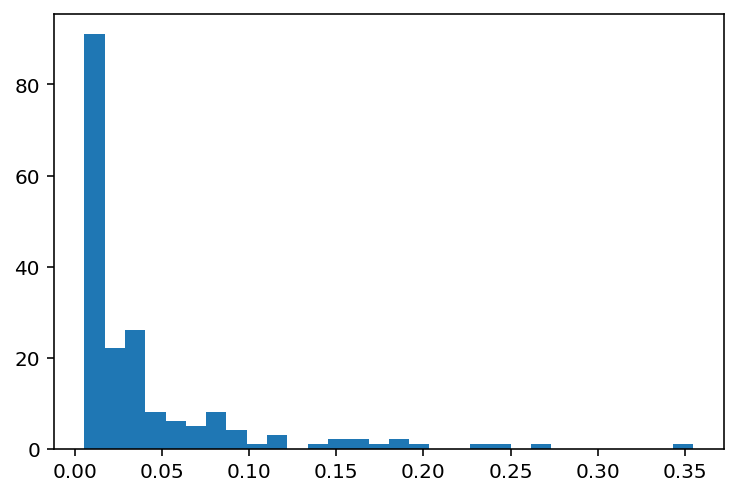

In [16]:
plt.hist(deg_cen_book1.values(), bins=30)
plt.show()

The above plot shows something that is expected, a high portion of characters aren't connected to lot of other characters while some characters are highly connected all through the network. A close real world example of this is a social network like Twitter where a few people have millions of connections(followers) but majority of users aren't connected to that many other users. This exponential decay like property resembles power law in real life networks.

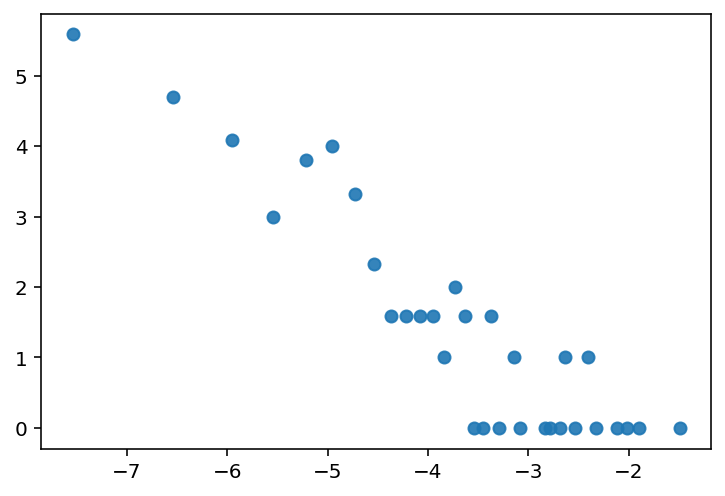

In [17]:
# A log-log plot to show the "signature" of power law in graphs.
from collections import Counter
hist = Counter(deg_cen_book1.values())
plt.scatter(np.log2(list(hist.keys())), np.log2(list(hist.values())), alpha=0.9)
plt.show()

### Exercise

Create a new centrality measure, weighted_degree(Graph, weight) which takes in Graph and the weight attribute and returns a weighted degree dictionary. Weighted degree is calculated by summing the weight of the all edges of a node and find the top five characters according to this measure.

In [ ]:
from nams.solutions.got import weighted_degree

plt.hist(list(weighted_degree(graphs[0], 'weight').values()), bins=30)
plt.show()

In [ ]:
sorted(weighted_degree(graphs[0], 'weight').items(), key=lambda x:x[1], reverse=True)[0:5]

## Betweeness centrality

Let's do this for Betweeness centrality and check if this makes any difference. As different centrality method use different measures underneath, they find nodes which are important in the network. A centrality method like Betweeness centrality finds nodes which are structurally important to the network, which binds the network together and densely.

In [18]:
# First check unweighted (just the structure)

sorted(nx.betweenness_centrality(graphs[0]).items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.2696038913836117),
 ('Robert-Baratheon', 0.21403028397371796),
 ('Tyrion-Lannister', 0.1902124972697492),
 ('Jon-Snow', 0.17158135899829566),
 ('Catelyn-Stark', 0.1513952715347627),
 ('Daenerys-Targaryen', 0.08627015537511595),
 ('Robb-Stark', 0.07298399629664767),
 ('Drogo', 0.06481224290874964),
 ('Bran-Stark', 0.05579958811784442),
 ('Sansa-Stark', 0.03714483664326785)]

In [19]:
# Let's care about interactions now

sorted(nx.betweenness_centrality(graphs[0], weight='weight_inv').items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.5926474861958733),
 ('Catelyn-Stark', 0.36855565242662014),
 ('Jon-Snow', 0.3514094739901191),
 ('Robert-Baratheon', 0.3329991281604185),
 ('Tyrion-Lannister', 0.27137460040685846),
 ('Daenerys-Targaryen', 0.202615518744551),
 ('Bran-Stark', 0.0945655332752107),
 ('Robb-Stark', 0.09177564661435629),
 ('Arya-Stark', 0.06939843068875327),
 ('Sansa-Stark', 0.06870095902353966)]

We can see there are some differences between the unweighted and weighted centrality measures. Another thing to note is that we are using the weight_inv attribute instead of weight(the number of interactions between characters). This decision is based on the way we want to assign the notion of "importance" of a character. The basic idea behind betweenness centrality is to find nodes which are essential to the structure of the network. As betweenness centrality computes shortest paths underneath, in the case of weighted betweenness centrality it will end up penalising characters with high number of interactions. By using weight_inv we will prop up the characters with high interactions with other characters.

## PageRank
The billion dollar algorithm, PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites.

NOTE: We don't need to worry about weight and weight_inv in PageRank as the algorithm uses weights in the opposite sense (larger weights are better). This may seem confusing as different centrality measures have different definition of weights. So it is always better to have a look at documentation before using weights in a centrality measure.

In [20]:
# by default weight attribute in pagerank is weight, so we use weight=None to find the unweighted results
sorted(nx.pagerank_numpy(graphs[0], weight=None).items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.045520792228306683),
 ('Tyrion-Lannister', 0.033013624624932694),
 ('Catelyn-Stark', 0.030193105286631904),
 ('Robert-Baratheon', 0.029834742227736702),
 ('Jon-Snow', 0.02683449952206624),
 ('Robb-Stark', 0.021562941297247534),
 ('Sansa-Stark', 0.020008034042864633),
 ('Bran-Stark', 0.01994578678623833),
 ('Jaime-Lannister', 0.017507847202846934),
 ('Cersei-Lannister', 0.017082604584758077)]

In [21]:
sorted(nx.pagerank_numpy(graphs[0], weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.07239401100498265),
 ('Robert-Baratheon', 0.0485172757050995),
 ('Jon-Snow', 0.047706890624749046),
 ('Tyrion-Lannister', 0.04367437892706306),
 ('Catelyn-Stark', 0.03466703470130745),
 ('Bran-Stark', 0.0297742005398002),
 ('Robb-Stark', 0.0292161836451969),
 ('Daenerys-Targaryen', 0.027089622513021133),
 ('Sansa-Stark', 0.026961778915683167),
 ('Cersei-Lannister', 0.02163167939741902)]

## Exercise

### Is there a correlation between these techniques?


Find the correlation between these four techniques.

- pagerank (weight = 'weight')
- betweenness_centrality (weight = 'weight_inv')
- weighted_degree
- degree centrality

HINT: Use pandas correlation 

In [ ]:
from nams.solutions.got import correlation_centrality

In [ ]:
correlation_centrality(graphs[0])

## Evolution of importance of characters over the books

According to degree centrality the most important character in the first book is Eddard Stark but he is not even in the top 10 of the fifth book. The importance changes over the course of five books, because you know stuff happens ;)

Let's look at the evolution of degree centrality of a couple of characters like Eddard Stark, Jon Snow, Tyrion which showed up in the top 10 of degree centrality in first book.

We create a dataframe with character columns and index as books where every entry is the degree centrality of the character in that particular book and plot the evolution of degree centrality Eddard Stark, Jon Snow and Tyrion.
We can see that the importance of Eddard Stark in the network dies off and with Jon Snow there is a drop in the fourth book but a sudden rise in the fifth book

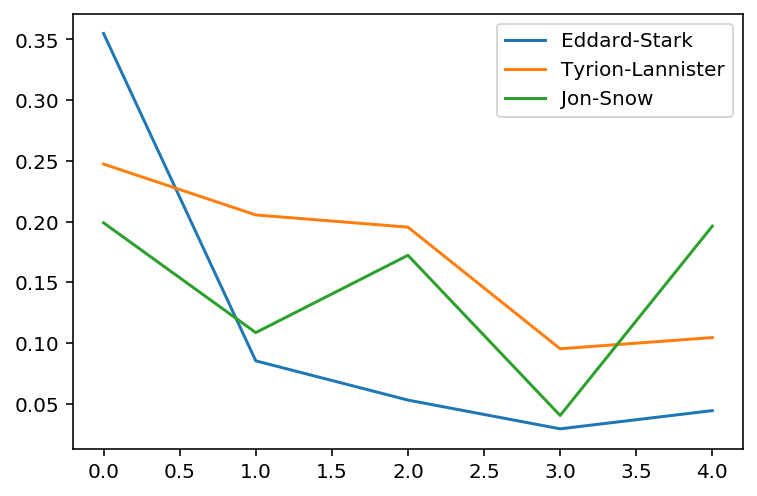

In [22]:
evol = [nx.degree_centrality(graph) for graph in graphs]
evol_df = pd.DataFrame.from_records(evol).fillna(0)
evol_df[['Eddard-Stark', 'Tyrion-Lannister', 'Jon-Snow']].plot()

In [23]:
set_of_char = set()
for i in range(5):
    set_of_char |= set(list(evol_df.T[i].sort_values(ascending=False)[0:5].index))
set_of_char

{'Arya-Stark',
 'Brienne-of-Tarth',
 'Catelyn-Stark',
 'Cersei-Lannister',
 'Daenerys-Targaryen',
 'Eddard-Stark',
 'Jaime-Lannister',
 'Joffrey-Baratheon',
 'Jon-Snow',
 'Margaery-Tyrell',
 'Robb-Stark',
 'Robert-Baratheon',
 'Sansa-Stark',
 'Stannis-Baratheon',
 'Theon-Greyjoy',
 'Tyrion-Lannister'}

## Exercise

Plot the evolution of betweenness centrality of the above mentioned characters over the 5 books.

In [ ]:
from nams.solution.got import evol_betweenness

In [ ]:
evol_betweenness(graphs)

## So what's up with Stannis Baratheon?

In [24]:
sorted(nx.degree_centrality(graphs[4]).items(), key=lambda x:x[1], reverse=True)[:5]

[('Jon-Snow', 0.1962025316455696),
 ('Daenerys-Targaryen', 0.18354430379746836),
 ('Stannis-Baratheon', 0.14873417721518986),
 ('Tyrion-Lannister', 0.10443037974683544),
 ('Theon-Greyjoy', 0.10443037974683544)]

In [25]:
sorted(nx.betweenness_centrality(graphs[4]).items(), key=lambda x:x[1], reverse=True)[:5]

[('Stannis-Baratheon', 0.45283060689247934),
 ('Daenerys-Targaryen', 0.2959459062106149),
 ('Jon-Snow', 0.24484873673158666),
 ('Tyrion-Lannister', 0.20961613179551256),
 ('Robert-Baratheon', 0.17716906651536968)]

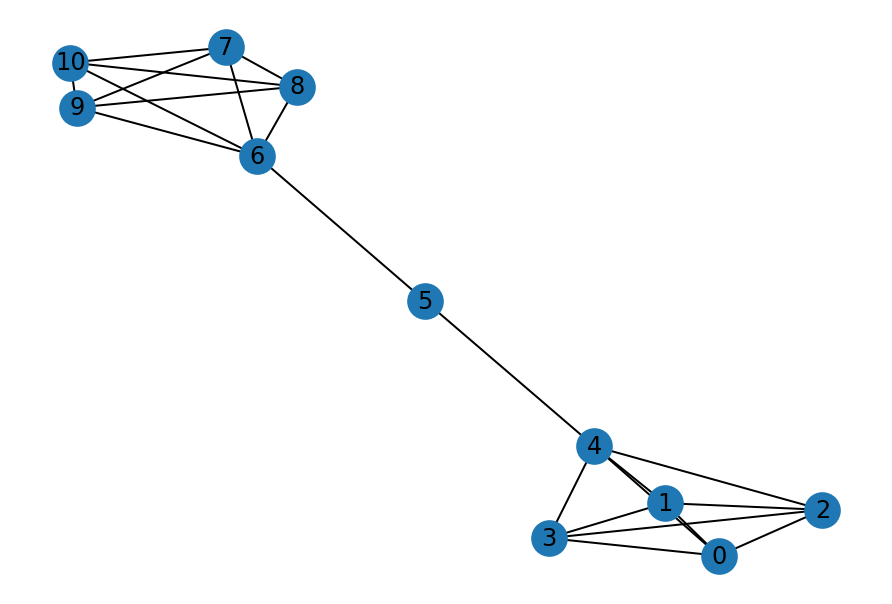

In [26]:
nx.draw(nx.barbell_graph(5, 1), with_labels=True)

As we know the a higher betweenness centrality means that the node is crucial for the structure of the network, and in the case of Stannis Baratheon in the fifth book it seems like Stannis Baratheon has characterstics similar to that of node 5 in the above example as it seems to be the holding the network together.

As evident from the betweenness centrality scores of the above example of barbell graph, node 5 is the most important node in this network.

In [27]:
nx.betweenness_centrality(nx.barbell_graph(5, 1))

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.5333333333333333,
 6: 0.5333333333333333,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 5: 0.5555555555555556}

## Community detection in Networks
A network is said to have community structure if the nodes of the network can be easily grouped into (potentially overlapping) sets of nodes such that each set of nodes is densely connected internally. There are multiple algorithms and definitions to calculate these communites in a network.

We will use louvain community detection algorithm to find the modules in our graph.

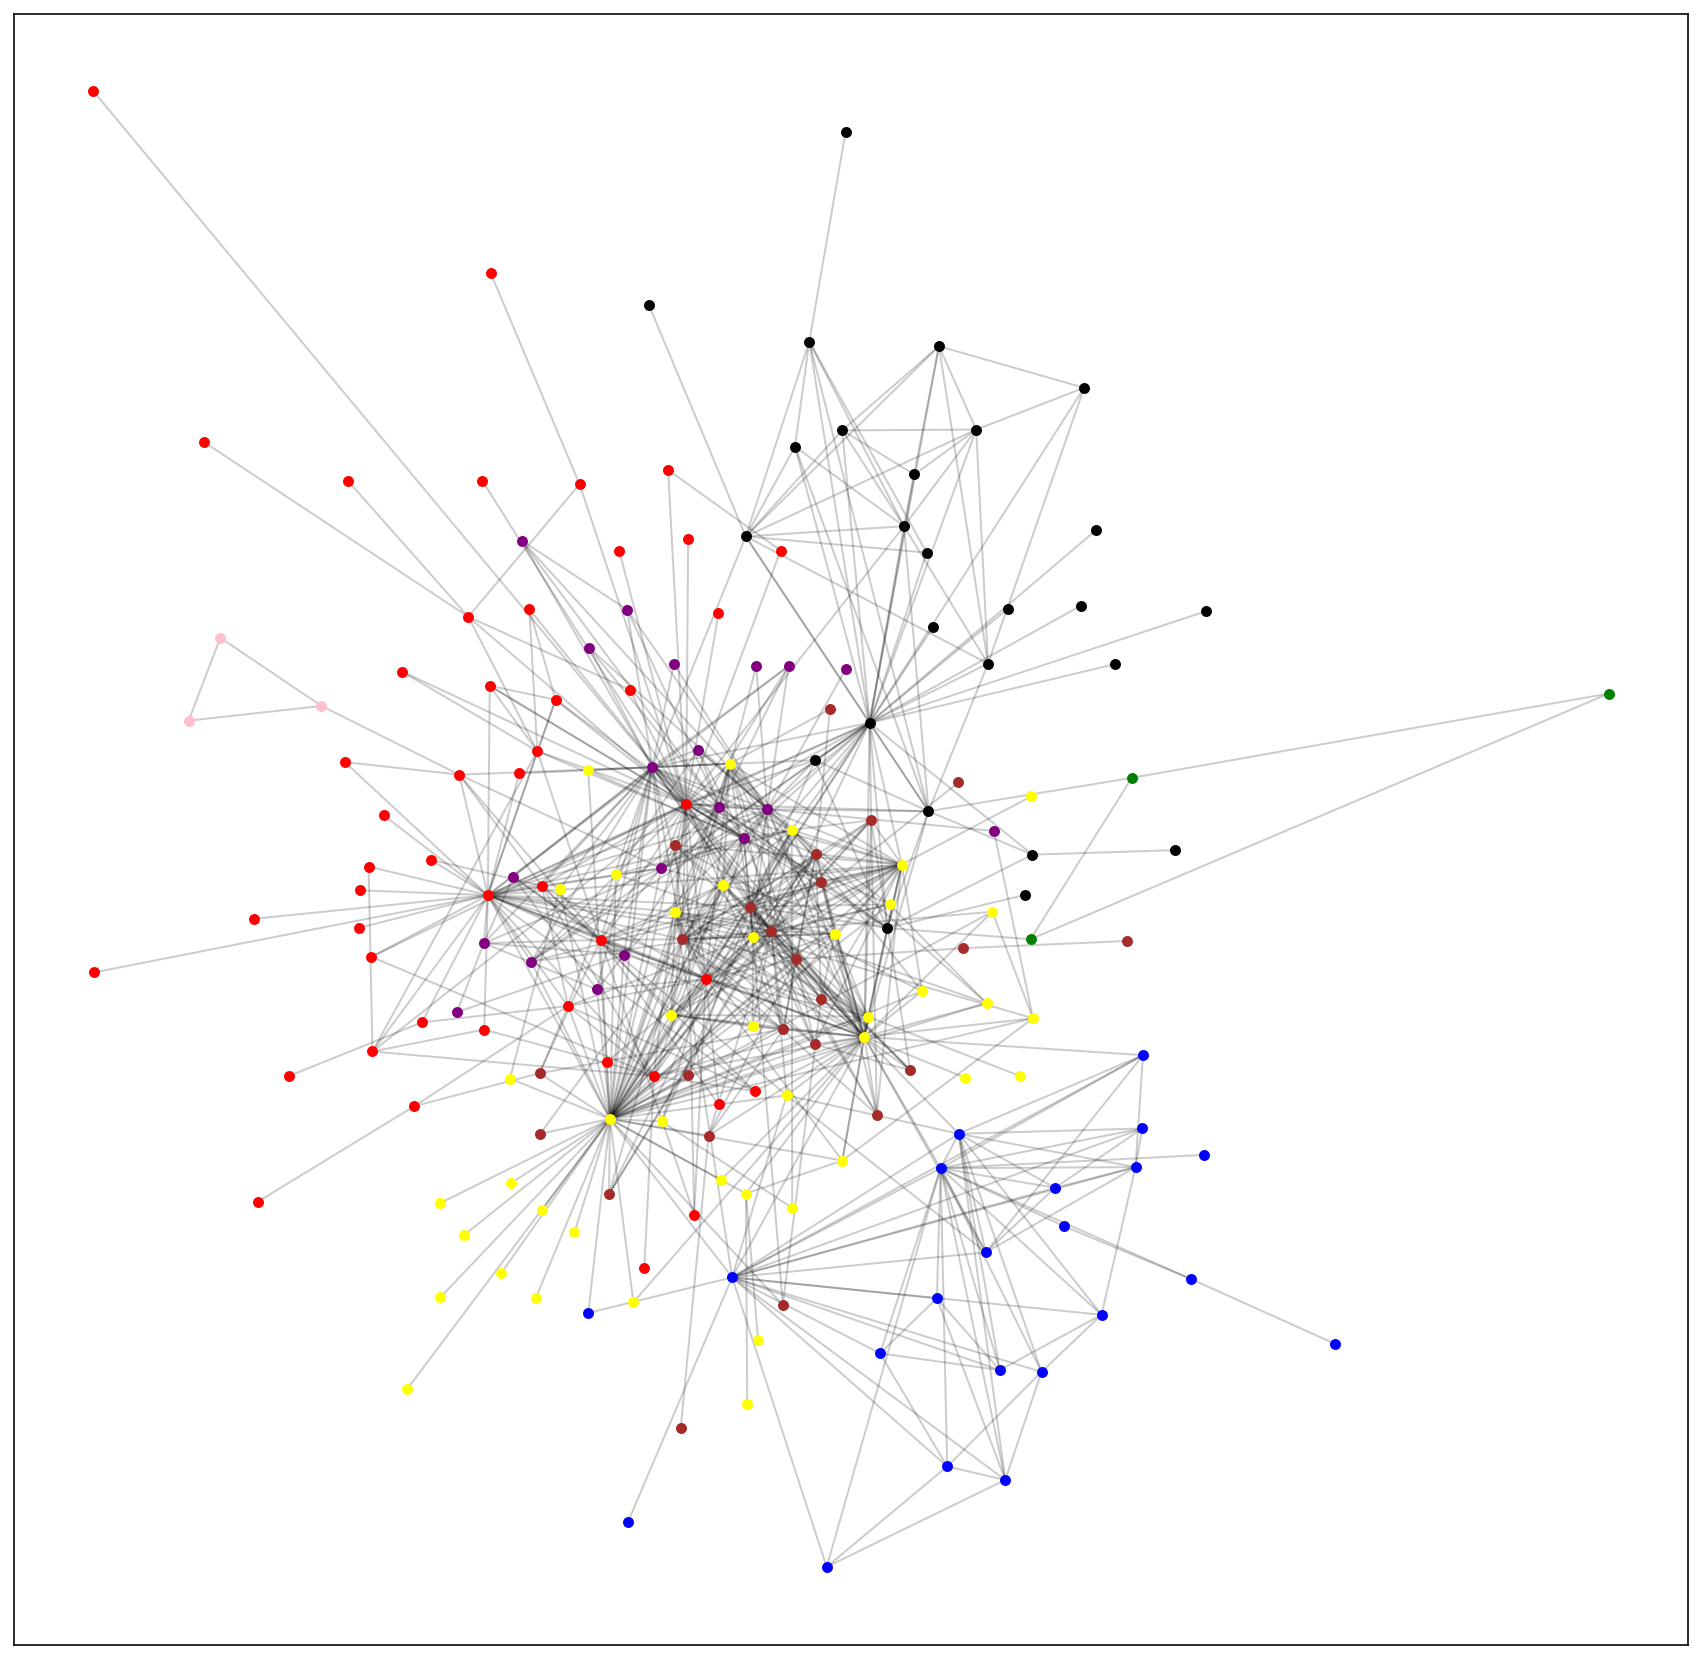

In [28]:
plt.figure(figsize=(15, 15))

partition = community.best_partition(graphs[0])
size = float(len(set(partition.values())))
pos = nx.kamada_kawai_layout(graphs[0])
count = 0
colors = ['red', 'blue', 'yellow', 'black', 'brown', 'purple', 'green', 'pink']
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(graphs[0], pos, list_nodes, node_size = 20,
                                node_color = colors[count])
    count = count + 1



nx.draw_networkx_edges(graphs[0], pos, alpha=0.2)
plt.show()

In [29]:
# louvain community detection find us 8 different set of communities
d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]

In [30]:
len(d)

8

In [31]:
d[2]

['Eddard-Stark',
 'Aerys-II-Targaryen',
 'Brandon-Stark',
 'Gerold-Hightower',
 'Jon-Arryn',
 'Robert-Baratheon',
 'Alyn',
 'Harwin',
 'Jory-Cassel',
 'Tomard',
 'Arthur-Dayne',
 'Cersei-Lannister',
 'Petyr-Baelish',
 'Vayon-Poole',
 'Arys-Oakheart',
 'Balon-Greyjoy',
 'Renly-Baratheon',
 'Barristan-Selmy',
 'Pycelle',
 'Varys',
 'Lyanna-Stark',
 'Cayn',
 'Janos-Slynt',
 'Stannis-Baratheon',
 'Rhaegar-Targaryen',
 'Daryn-Hornwood',
 'Torrhen-Karstark',
 'Gendry',
 'Howland-Reed',
 'Jacks',
 'Joss',
 'Porther',
 'Raymun-Darry',
 'Tobho-Mott',
 'Tregar',
 'Varly',
 'Wyl-(guard)',
 'Wylla',
 'Oswell-Whent',
 'Heward',
 'Hugh',
 'Lancel-Lannister']

If we plot these communities of the network we see a denser network as compared to the original network which contains all the characters.

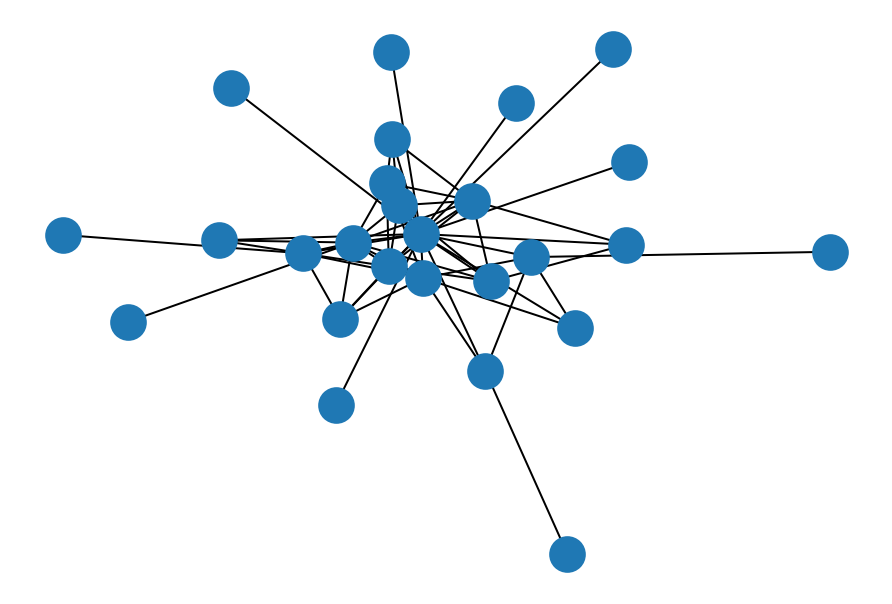

In [32]:
nx.draw(nx.subgraph(graphs[0], d[3]))

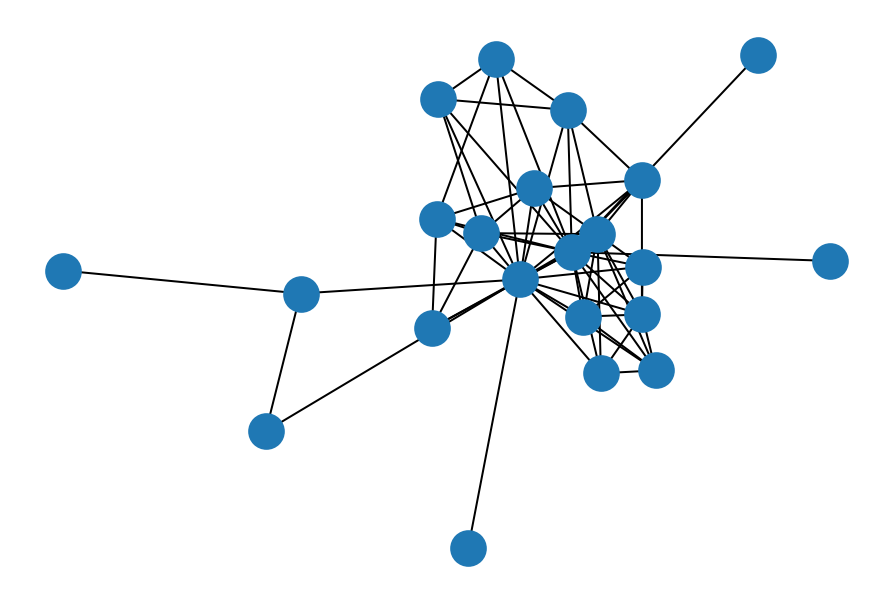

In [33]:
nx.draw(nx.subgraph(graphs[0], d[1]))

We can test this by calculating the density of the network and the community.

Like in the following example the network between characters in a community is 5 times more dense than the original network.

In [34]:
nx.density(nx.subgraph(graphs[0], d[4]))/nx.density(graphs[0])

5.066663488431223

## Exercise 

Find the most important node in the partitions according to degree centrality of the nodes.

In [ ]:
from nams.solution.got import most_important_node_in_partition

In [ ]:
most_important_node_in_partition(graphs[0])